# Clustering Circuits

Importing necessary packages

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

Recovering cleaned circuits data through the procedure indicate with 

In [5]:
cluster_data=pd.read_excel('cluster_data.xlsx')

Defining the function that double-check that data where actually cleaned accurately and remove eventual `NA` values.

In [6]:
def prepare_data(df):
    """
    Prepare the data for clustering by selecting numerical features and scaling them.
    """
    numerical_columns = [
        'Full_throttle_percentage', 'NumSharpCorner',
        'NumMidCorner', 'NumOpenCorner', 'AverageQ1Time',
        'Length(m)', 'avg_speed_kmh'
    ]
    
    # Create a feature matrix
    X = df[numerical_columns].copy()
    
    # Double-checking for missing values
    X = X.fillna(X.mean())
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, numerical_columns

## Hierarchical Clustering

This code performs hierarchical clustering to analyze and group Formula 1 circuits based on their characteristics. Here are the steps:

* `plot_dendrogram`: Visualizes hierarchical clustering to help select the optimal number of clusters.
* `perform_hierarchical_clustering`: Groups circuits into clusters based on their features.
* `visualize_clusters_pca`: Reduces data to two dimensions using PCA and visualizes the clusters.
* `create_feature_importance_plot`: Displays feature differences across clusters using a heatmap.
* `analyze_clusters`: Provides detailed insights into cluster composition and circuit characteristics.
<br>

The `main` function integrates these steps, producing visualizations and cluster analysis for actionable insights.

In [7]:
def plot_dendrogram(X_scaled, df, max_d=None):
    """
    Plot dendrogram to help determine optimal number of clusters.
    """
    plt.figure(figsize=(15, 8))
    
    # Create linkage matrix
    linkage_matrix = linkage(X_scaled, method='ward')
    
    # Plot dendrogram
    dendrogram(linkage_matrix, labels=df['Circuit'].values, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Circuit')
    plt.ylabel('Distance')
    
    if max_d:
        plt.axhline(y=max_d, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.savefig('figures/dendrogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return linkage_matrix

def calculate_cophenetic_correlation(X_scaled, linkage_matrix):
    """
    Calculate cophenetic correlation coefficient to evaluate clustering quality.
    """
    original_distances = pdist(X_scaled)
    cophenetic_distances = cophenet(linkage_matrix)
    correlation = np.corrcoef(original_distances, cophenetic_distances)[0, 1]
    return correlation

def perform_hierarchical_clustering(X_scaled, n_clusters):
    """
    Perform hierarchical clustering with specified number of clusters.
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering.fit_predict(X_scaled)
    return cluster_labels

def visualize_clusters_pca(X_scaled, df_clustered):
    """
    Visualize clusters using PCA.
    """
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=df_clustered['Cluster'],
                         cmap='viridis')
    
    # Add circuit labels
    for i, txt in enumerate(df_clustered['Circuit']):
        plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), 
                    fontsize=8, alpha=0.7)
    
    plt.colorbar(scatter)
    plt.title('Circuit Clusters Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.tight_layout()
    plt.savefig('figures/pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_feature_importance_plot(X_scaled, numerical_columns, cluster_labels):
    """
    Create feature importance plot for each cluster.
    """
    cluster_means = pd.DataFrame(X_scaled, columns=numerical_columns)
    cluster_means['Cluster'] = cluster_labels
    
    cluster_profiles = cluster_means.groupby('Cluster').mean()
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(cluster_profiles, cmap='RdYlBu', center=0,
                annot=True, fmt='.2f')
    plt.title('Feature Importance by Cluster')
    plt.xlabel('Features')
    plt.ylabel('Cluster')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_clusters(df_clustered):
    """
    Print detailed analysis of each cluster.
    """
    numerical_cols = [
        'Full_throttle_percentage', 'NumSharpCorner',
        'NumMidCorner', 'NumOpenCorner', 'avg_speed_kmh','Length(m)'
    ]
    
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_circuits = df_clustered[df_clustered['Cluster'] == cluster]
        print(f"\nCluster {cluster} Analysis:")
        print("="* 50)
        print(f"Number of circuits: {len(cluster_circuits)}")
        
        print("\nCircuits:")
        for circuit in cluster_circuits['Circuit'].unique():
            print(f"- {circuit}")
        
        print("\nCharacteristics (Mean Values):")
        numeric_means = cluster_circuits[numerical_cols].mean().round(2)
        for col, value in numeric_means.items():
            print(f"{col:25}: {value:8.2f}")
        
        print("\nCharacteristics (Standard Deviation):")
        numeric_std = cluster_circuits[numerical_cols].std().round(2)
        for col, value in numeric_std.items():
            print(f"{col:25}: {value:8.2f}")
        
        print("\nCircuit Types:")
        type_counts = cluster_circuits['Type'].value_counts()
        for circuit_type, count in type_counts.items():
            print(f"- {circuit_type}: {count}")
        
        print("="* 50)

def main(df, n_clusters=4):
    """
    Main function to run the hierarchical clustering analysis.
    """
    # Prepare the data
    X_scaled, numerical_columns = prepare_data(df)
    
    # Plot dendrogram
    print("Generating dendrogram...")
    linkage_matrix = plot_dendrogram(X_scaled, df)
    
    # Perform hierarchical clustering
    print(f"\nPerforming hierarchical clustering with {n_clusters} clusters...")
    cluster_labels = perform_hierarchical_clustering(X_scaled, n_clusters)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['Cluster'] = cluster_labels
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_clusters_pca(X_scaled, df_clustered)
    create_feature_importance_plot(X_scaled, numerical_columns, cluster_labels)
    
    # Analyze clusters
    print("\nDetailed cluster analysis:")
    analyze_clusters(df_clustered)
    
    return df_clustered

Computing the actual clusterization, printing the graphs, and printing the data.

Generating dendrogram...


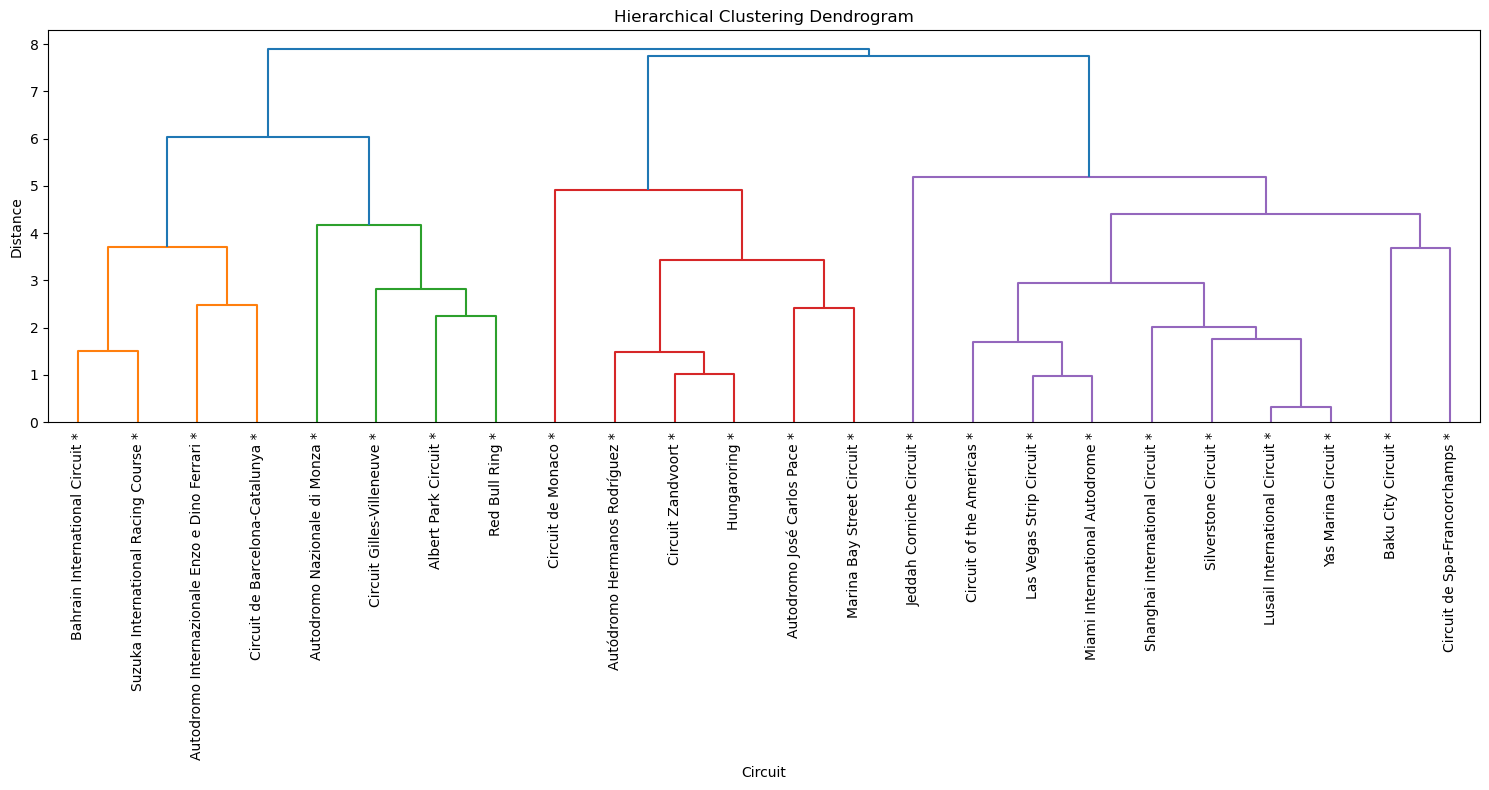


Performing hierarchical clustering with 4 clusters...

Generating visualizations...


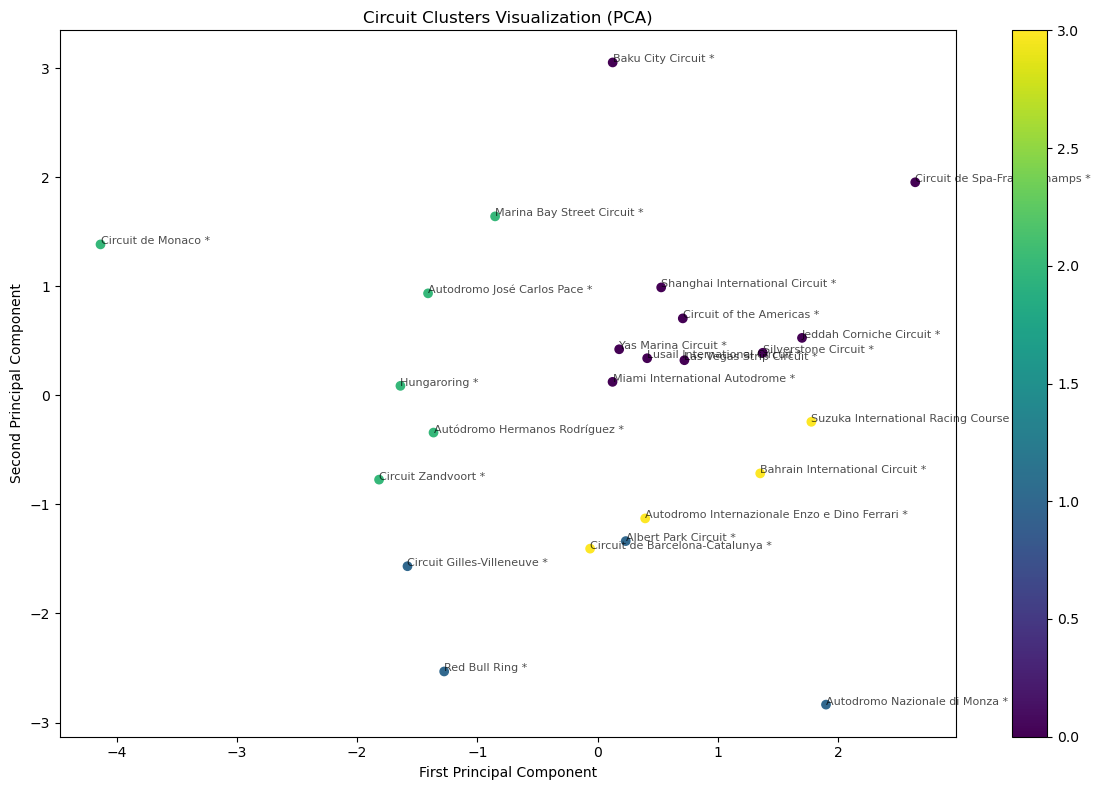

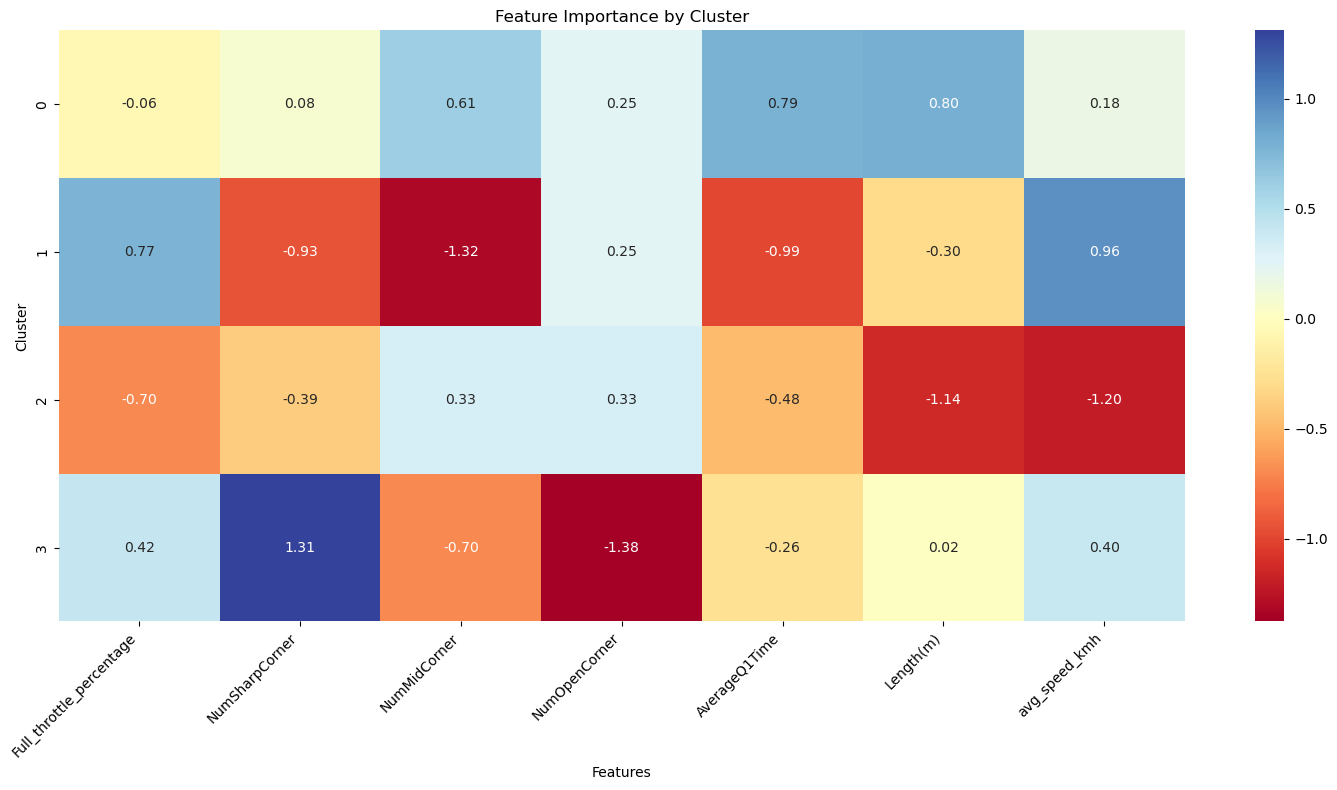


Detailed cluster analysis:

Cluster 0 Analysis:
Number of circuits: 10

Circuits:
- Circuit of the Americas *
- Las Vegas Strip Circuit *
- Miami International Autodrome *
- Baku City Circuit *
- Circuit de Spa-Francorchamps *
- Jeddah Corniche Circuit *
- Lusail International Circuit *
- Shanghai International Circuit *
- Silverstone Circuit *
- Yas Marina Circuit *

Characteristics (Mean Values):
Full_throttle_percentage :     0.61
NumSharpCorner           :     9.25
NumMidCorner             :     4.88
NumOpenCorner            :     4.62
avg_speed_kmh            :   227.94
Length(m)                :  5834.90

Characteristics (Standard Deviation):
Full_throttle_percentage :     0.05
NumSharpCorner           :     2.87
NumMidCorner             :     1.46
NumOpenCorner            :     2.20
avg_speed_kmh            :    16.21
Length(m)                :   533.00

Circuit Types:
- Race circuit: 6
- Street circuit: 4

Cluster 1 Analysis:
Number of circuits: 4

Circuits:
- Autodromo Nazion

In [8]:
df_clustered = main(cluster_data,n_clusters=4)

# F1 Circuits Hierarchical Clustering Analysis

This project performs hierarchical clustering analysis on Formula 1 circuits based on their physical characteristics and performance metrics. The analysis groups similar circuits together to identify patterns and relationships between different tracks.

## Overview

The analysis clusters F1 circuits using the following features:
- Full throttle percentage
- Number of turns
- Corner types (Sharp, Mid, Open)
- Average speed
- Corner speeds for different types

## Clustering Results Visualization

### Hierarchical Clustering Dendrogram
![Hierarchical Clustering Dendrogram](./figures/dendrogram.png)

The dendrogram above shows the hierarchical relationship between circuits, with the vertical axis representing the distance or dissimilarity between clusters. The colors indicate different main clusters identified in the analysis.

### Feature Importance Heatmap
![Feature Importance by Cluster](./figures/feature_importance.png)

The heatmap displays the relative importance of different features for each cluster, with darker blue indicating higher values and darker orange indicating lower values. This visualization helps understand what characteristics define each cluster.

### PCA Visualization
![Circuit Clusters PCA](./figures/pca_visualization.png)

The PCA plot shows the circuits projected onto two dimensions, with colors indicating cluster membership. This visualization helps understand the spatial relationships between circuits and clusters.

## Key Findings

The analysis identified 4 distinct clusters of circuits:

### Cluster 0 (High-Speed Technical Circuits)
- Largest group with 11 circuits including Circuit of the Americas, Silverstone, and Suzuka
- Characterized by:
  - Highest average full throttle percentage (61%)
  - Balanced mix of corner types
  - High average speed (225 km/h)
- Predominantly purpose-built race circuits (8 out of 11)

### Cluster 1 (Technical Circuits)
- 6 circuits including Monaco, Hungaroring, and Marina Bay
- Characterized by:
  - Lowest full throttle percentage (55%)
  - Lower average speeds (198 km/h)
  - More technical sections with emphasis on sharp corners
- Mix of street circuits and traditional race tracks

### Cluster 2 (High-Speed Circuits)
- 6 circuits including Monza, Barcelona, and Red Bull Ring
- Characterized by:
  - Highest full throttle percentage (69%)
  - Fewer total turns (13.5 average)
  - High average speed (241 km/h)
- Focus on speed with fewer technical sections

### Cluster 3 (Unique Case - Jeddah)
- Single circuit cluster
- Characterized by:
  - Extremely high number of turns (27)
  - Highest number of sharp corners (15)
  - Highest average speed (254 km/h)
- Unique combination of high-speed sections with technical complexity

## Code Structure

### Main Functions

1. `plot_dendrogram(X_scaled, df, max_d=None)`
   - Generates hierarchical clustering dendrogram
   - Helps visualize the clustering hierarchy
   - Optional cutoff line for cluster determination

2. `calculate_cophenetic_correlation(X_scaled, linkage_matrix)`
   - Evaluates clustering quality
   - Returns correlation coefficient between original and cophenetic distances

3. `perform_hierarchical_clustering(X_scaled, n_clusters)`
   - Executes the hierarchical clustering algorithm
   - Returns cluster labels for each circuit

4. `visualize_clusters_pca(X_scaled, df_clustered)`
   - Creates PCA visualization of clusters
   - Projects high-dimensional data onto 2D space
   - Includes circuit labels and color coding

5. `create_feature_importance_plot(X_scaled, numerical_columns, cluster_labels)`
   - Generates heatmap of feature importance by cluster
   - Helps interpret cluster characteristics

6. `analyze_clusters(df_clustered)`
   - Provides detailed statistical analysis of each cluster
   - Includes means, standard deviations, and circuit types

## Usage

```python
# Import required libraries and prepare your dataset
df = # your F1 circuits dataset

# Run the complete analysis
df_clustered = main(df, n_clusters=4)
```

## Dependencies

- NumPy
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn

## Notes

- The analysis uses Ward's method for hierarchical clustering
- Features are scaled before clustering to ensure equal weighting
- PCA is used for visualization purposes only, clustering is performed on the full feature set

## Future Improvements

1. Include additional circuit characteristics:
   - Elevation changes
   - Weather conditions
3. Incorporate race performance statistics
4. Add interactive visualizations

## Contributing

Feel free to fork this repository and submit pull requests with improvements or additional analyses.
